# Protein MD Setup tutorial using BioExcel Building Blocks (biobb) 
### --***AmberTools package version***--
**Based on the [MDWeb](http://mmb.irbbarcelona.org/MDWeb2/) [Amber FULL MD Setup tutorial](https://mmb.irbbarcelona.org/MDWeb2/help.php?id=workflows#AmberWorkflowFULL)**

***
This tutorial aims to illustrate the process of **setting up a simulation system** containing a **protein**, step by step, using the **BioExcel Building Blocks library (biobb)** wrapping the **AmberTools** utility from the **AMBER package**. The particular example used is the **Lysozyme** protein (PDB code 1AKI, [https://doi.org/10.2210/pdb1AKI/pdb](https://doi.org/10.2210/pdb1AKI/pdb)). 
***

## Settings

### Biobb modules used

 - [biobb_io](https://github.com/bioexcel/biobb_io): Tools to fetch biomolecular data from public databases.
 - [biobb_amber](https://github.com/bioexcel/biobb_amber): Tools to setup and run Molecular Dynamics simulations with AmberTools.
 - [biobb_analysis](https://github.com/bioexcel/biobb_analysis): Tools to analyse Molecular Dynamics trajectories.
 
### Auxiliary libraries used

* [jupyter](https://jupyter.org/): Free software, open standards, and web services for interactive computing across all programming languages.
* [plotly](https://plot.ly/python/offline/): Python interactive graphing library integrated in Jupyter notebooks.
* [nglview](https://nglviewer.org/#nglview): Jupyter/IPython widget to interactively view molecular structures and trajectories in notebooks.
* [simpletraj](https://github.com/arose/simpletraj): Lightweight coordinate-only trajectory reader based on code from GROMACS, MDAnalysis and VMD.
* [gfortran](https://anaconda.org/conda-forge/gfortran): Fortran 95/2003/2008/2018 compiler for GCC, the GNU Compiler Collection.
* [libgfortran5](https://anaconda.org/conda-forge/libgfortran5): Fortran compiler and libraries from the GNU Compiler Collection.

### Conda Installation

```console
git clone https://github.com/bioexcel/biobb_wf_amber.git
cd biobb_wf_amber
conda env create -f conda_env/environment.yml
conda activate biobb_wf_amber
jupyter-notebook biobb_wf_amber/notebooks/md_setup/biobb_wf_amber_md_setup.ipynb
```

***
## Pipeline steps
 1. [Input Parameters](#input)
 2. [Fetching PDB Structure](#fetch)
 3. [Preparing PDB file for AMBER](#pdb4amber)
 4. [Create Protein System Topology](#top)
 5. [Energetically Minimize the Structure](#minv)
 6. [Create Solvent Box and Solvating the System](#box)
 7. [Adding Ions](#ions)
 8. [Energetically Minimize the System](#min)
 9. [Heating the System](#heating)
 10. [Equilibrate the System (NVT)](#nvt)
 11. [Equilibrate the System (NPT)](#npt)
 12. [Free Molecular Dynamics Simulation](#free)
 13. [Post-processing and Visualizing Resulting 3D Trajectory](#post)
 14. [Output Files](#output)
 15. [Questions & Comments](#questions)
 
***
<img src="https://bioexcel.eu/wp-content/uploads/2019/04/Bioexcell_logo_1080px_transp.png" alt="Bioexcel2 logo"
	title="Bioexcel2 logo" width="400" />
***


## Initializing colab
The two cells below are used only in case this notebook is executed via **Google Colab**. Take into account that, for running conda on **Google Colab**, the **condacolab** library must be installed. As [explained here](https://pypi.org/project/condacolab/), the installation requires a **kernel restart**, so when running this notebook in **Google Colab**, don't run all cells until this **installation** is properly **finished** and the **kernel** has **restarted**.

In [1]:
# Only executed when using google colab
import sys
if 'google.colab' in sys.modules:
  import subprocess
  from pathlib import Path
  try:
    subprocess.run(["conda", "-V"], check=True)
  except FileNotFoundError:
    subprocess.run([sys.executable, "-m", "pip", "install", "condacolab"], check=True)
    import condacolab
    condacolab.install()
    # Clone repository
    repo_URL = "https://github.com/bioexcel/biobb_wf_amber.git"
    repo_name = Path(repo_URL).name.split('.')[0]
    if not Path(repo_name).exists():
      subprocess.run(["mamba", "install", "-y", "git"], check=True)
      subprocess.run(["git", "clone", repo_URL], check=True)
      print("⏬ Repository properly cloned.")
    # Install environment
    print("⏳ Creating environment...")
    env_file_path = f"{repo_name}/conda_env/environment.yml"
    subprocess.run(["mamba", "env", "update", "-n", "base", "-f", env_file_path], check=True)
    print("🎨 Install NGLView dependencies...")
    subprocess.run(["mamba", "install", "-y", "-c", "conda-forge", "nglview==3.0.8", "ipywidgets=7.7.2"], check=True)
    subprocess.run([sys.executable, "-m", "pip", "install", "numpy<2", "--upgrade", "--force-reinstall"], check=True)
    print("👍 Conda environment successfully created and updated.")

In [2]:
# Enable widgets for colab
if 'google.colab' in sys.modules:
  from google.colab import output
  output.enable_custom_widget_manager()
  # Change working dir
  import os
  os.chdir("biobb_wf_amber/biobb_wf_amber/notebooks/md_setup")
  print(f"📂 New working directory: {os.getcwd()}")

<a id="input"></a>
## Input parameters
**Input parameters** needed:
 - **pdbCode**: PDB code of the protein structure (e.g. 1AKI, [https://doi.org/10.2210/pdb1AKI/pdb](https://doi.org/10.2210/pdb1AKI/pdb))

In [3]:
import nglview
import ipywidgets
import plotly
import sys
from plotly import subplots
import plotly.graph_objs as go

pdbCode = "1aki"

/Users/gbayarri/miniconda3/envs/biobb_wf_amber/lib/python3.12/site-packages/nglview/__init__.py:12: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


<a id="fetch"></a>
***
## Fetching PDB structure
Downloading **PDB structure** with the **protein molecule** from the RCSB PDB database.<br>
Alternatively, a **PDB file** can be used as starting structure. <br>
***
**Building Blocks** used:
 - [pdb](https://biobb-io.readthedocs.io/en/latest/api.html#module-api.pdb) from **biobb_io.api.pdb**
***

In [4]:
# Import module
from biobb_io.api.pdb import pdb

# Create properties dict and inputs/outputs
downloaded_pdb = pdbCode+'.pdb'

prop = {
    'pdb_code': pdbCode
}

#Create and launch bb
pdb(output_pdb_path=downloaded_pdb,
    properties=prop)

2025-07-31 15:50:31,381 [MainThread  ] [INFO ]  Module: biobb_io.api.pdb Version: 5.1.0
2025-07-31 15:50:31,382 [MainThread  ] [INFO ]  Downloading 1aki from: https://www.ebi.ac.uk/pdbe/entry-files/download/pdb1aki.ent
2025-07-31 15:50:31,630 [MainThread  ] [INFO ]  Writting pdb to: 1aki.pdb
2025-07-31 15:50:31,632 [MainThread  ] [INFO ]  Filtering lines NOT starting with one of these words: ['ATOM', 'MODEL', 'ENDMDL']
2025-07-31 15:50:31,641 [MainThread  ] [INFO ]  


0

<a id="vis3D"></a>
### Visualizing 3D structure
Visualizing the downloaded/given **PDB structure** using **NGL**:    

In [5]:
# Show protein
view = nglview.show_structure_file(downloaded_pdb)
view.add_representation(repr_type='ball+stick', selection='all')
view._remote_call('setSize', target='Widget', args=['','600px'])
view

NGLWidget()

<a id="pdb4amber"></a>
***
## Preparing PDB file for AMBER
Before starting a **protein MD setup**, it is always strongly recommended to take a look at the initial structure and try to identify important **properties** and also possible **issues**. These properties and issues can be serious, as for example the definition of **disulfide bridges**, the presence of a **non-standard aminoacids** or **ligands**, or **missing residues**. Other **properties** and **issues** might not be so serious, but they still need to be addressed before starting the **MD setup process**. **Missing hydrogen atoms**, presence of **alternate atomic location indicators** or **inserted residue codes** (see [PDB file format specification](https://www.wwpdb.org/documentation/file-format-content/format33/sect9.html#ATOM)) are examples of these not so crucial characteristics. Please visit the [AMBER tutorial: Building Protein Systems in Explicit Solvent](http://ambermd.org/tutorials/basic/tutorial7/index.php) for more examples. **AmberTools** utilities from **AMBER MD package** contain a tool able to analyse **PDB files** and clean them for further usage, especially with the **AmberTools LEaP program**: the **pdb4amber tool**. The next step of the workflow is running this tool to analyse our **input PDB structure**.<br>

For the particular **Lysosyme** example, the most important property that is identified by the **pdb4amber** utility is the presence of **disulfide bridges** in the structure. Those are marked changing the residue names **from CYS to CYX**, which is the code that **AMBER force fields** use to distinguish between cysteines forming or not forming **disulfide bridges**. This will be used in the following step to correctly form a **bond** between these cysteine residues. 

We invite you to check what the tool does with different, more complex structures (e.g. PDB code [6N3V](https://www.rcsb.org/structure/6N3V)). 

***
**Building Blocks** used:
 - [pdb4amber_run](https://biobb-amber.readthedocs.io/en/latest/pdb4amber.html#pdb4amber-pdb4amber-run-module) from **biobb_amber.pdb4amber.pdb4amber_run**
***

In [6]:
# Import module
from biobb_amber.pdb4amber.pdb4amber_run import pdb4amber_run

# Create prop dict and inputs/outputs
output_pdb4amber_path = 'structure.pdb4amber.pdb'

# Create and launch bb
pdb4amber_run(  input_pdb_path=downloaded_pdb,
            output_pdb_path=output_pdb4amber_path)

2025-07-31 15:50:31,701 [MainThread  ] [INFO ]  Module: biobb_amber.pdb4amber.pdb4amber_run Version: 5.1.0
2025-07-31 15:50:31,703 [MainThread  ] [INFO ]  /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_90b440e2-dcd7-4c73-8719-7c8b9d1ea468 directory successfully created
2025-07-31 15:50:31,704 [MainThread  ] [INFO ]  Copy: 1aki.pdb to /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_90b440e2-dcd7-4c73-8719-7c8b9d1ea468
2025-07-31 15:50:31,705 [MainThread  ] [INFO ]  Creating 502aa6c6-ec06-4209-8fa5-7d37277e6448 temporary folder
2025-07-31 15:50:31,706 [MainThread  ] [INFO ]  pdb4amber -i /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_90b440e2-dcd7-4c73-8719-7c8b9d1ea468/1aki.pdb -o /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_90b440e2-dcd7-4c73-8719-7c8b9d1ea468/structure.pdb4amber.pdb

2025-07-31 15:50:32,463 [MainThread  ] [INFO ]  Executing: pdb4amber -i /Users/gbayarri/biobb_wf_am

0

<a id="top"></a>
***
## Create protein system topology
**Building AMBER topology** corresponding to the protein structure.<br>

*IMPORTANT: the previous pdb4amber building block is changing the proper cysteines residue naming in the PDB file from CYS to CYX so that this step can automatically identify and add the disulfide bonds to the system topology.*<br>

The **force field** used in this tutorial is [**ff14SB**](https://doi.org/10.1021/acs.jctc.5b00255), an evolution of the **ff99SB** force field with improved accuracy of protein side chains and backbone parameters. **Water** molecules type used in this tutorial is [**tip3p**](https://doi.org/10.1021/jp003020w).<br>
Adding **side chain atoms** and **hydrogen atoms** if missing. Forming **disulfide bridges** according to the info added in the previous step. <br>

Generating three output files: 
- **AMBER structure** (PDB file)
- **AMBER topology** (AMBER [Parmtop](https://ambermd.org/FileFormats.php#topology) file)
- **AMBER coordinates** (AMBER [Coordinate/Restart](https://ambermd.org/FileFormats.php#restart) file) 
***
**Building Blocks** used:
 - [leap_gen_top](https://biobb-amber.readthedocs.io/en/latest/leap.html#module-leap.leap_gen_top) from **biobb_amber.leap.leap_gen_top**
***

In [7]:
# uncomment ALWAYS when running in Google Colab:
# import os
# os.environ['AMBERHOME'] = "/usr/local"

In [8]:
# uncomment in case of experiencing issues with undefined AMBERHOME variable in the cell below (when running in Jupyter Notebook / Lab):
# import os
# os.environ['AMBERHOME'] = "/path/to/anaconda3/envs/biobb_wf_amber"

In [9]:
# Import module
from biobb_amber.leap.leap_gen_top import leap_gen_top

# Create prop dict and inputs/outputs
output_pdb_path = 'structure.leap.pdb'
output_top_path = 'structure.leap.top'
output_crd_path = 'structure.leap.crd'

prop = {
    "forcefield" : ["protein.ff14SB"]
}

# Create and launch bb
leap_gen_top(input_pdb_path=output_pdb4amber_path,
           #input_pdb_path=downloaded_pdb,
           output_pdb_path=output_pdb_path,
           output_top_path=output_top_path,
           output_crd_path=output_crd_path,
           properties=prop)

2025-07-31 15:50:32,481 [MainThread  ] [INFO ]  Module: biobb_amber.leap.leap_gen_top Version: 5.1.0
2025-07-31 15:50:32,481 [MainThread  ] [INFO ]  /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_6c75a6db-064b-4fb0-a8cf-bd5bab520498 directory successfully created
2025-07-31 15:50:32,482 [MainThread  ] [INFO ]  Copy: structure.pdb4amber.pdb to /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_6c75a6db-064b-4fb0-a8cf-bd5bab520498
2025-07-31 15:50:32,483 [MainThread  ] [INFO ]  Creating 4bdfa312-1afe-487f-b04b-7f0d361074aa temporary folder
2025-07-31 15:50:32,484 [MainThread  ] [INFO ]  tleap -f 4bdfa312-1afe-487f-b04b-7f0d361074aa/leap.in

2025-07-31 15:50:32,707 [MainThread  ] [INFO ]  Executing: tleap -f 4bdfa312-1afe-487f-b04b-7f0d361074aa/leap.in...
2025-07-31 15:50:32,708 [MainThread  ] [INFO ]  Exit code: 0
2025-07-31 15:50:32,708 [MainThread  ] [INFO ]  -I: Adding /Users/gbayarri/miniconda3/envs/biobb_wf_amber/dat/leap/prep to searc

0

### Visualizing 3D structure
Visualizing the **PDB structure** using **NGL**. <br>
Try to identify the differences between the structure generated for the **system topology** and the **original one** (e.g. hydrogen atoms).   

In [10]:
# Show protein
view = nglview.show_structure_file(output_pdb_path)
view.add_representation(repr_type='ball+stick', selection='all')
view._remote_call('setSize', target='Widget', args=['','600px'])
view

NGLWidget()

<a id="minv"></a>
## Energetically minimize the structure

**Energetically minimize** the **protein structure** (in vacuo) using the **sander tool** from the **AMBER MD package**. This step is **relaxing the structure**, usually **constrained**, especially when coming from an X-ray **crystal structure**. <br/>

The **miminization process** is done in two steps:
- [Step 1](#minv_1): **Hydrogen** minimization, applying **position restraints** (50 Kcal/mol.$Å^{2}$) to the **protein heavy atoms**.
- [Step 2](#minv_2): **System** minimization, applying **position restraints** (50 Kcal/mol.$Å^{2}$) to the **protein heavy atoms**.
***
**Building Blocks** used:
 - [sander_mdrun](https://biobb-amber.readthedocs.io/en/latest/sander.html#module-sander.sander_mdrun) from **biobb_amber.sander.sander_mdrun**
 - [process_minout](https://biobb-amber.readthedocs.io/en/latest/process.html#module-process.process_minout) from **biobb_amber.process.process_minout**
***

<a id="minv_1"></a>
### Step 1: Minimize Hydrogens
**Hydrogen** minimization, applying **position restraints** (50 Kcal/mol.$Å^{2}$) to the **protein heavy atoms**.

In [11]:
# Import module
from biobb_amber.sander.sander_mdrun import sander_mdrun

# Create prop dict and inputs/outputs
output_h_min_traj_path = 'sander.h_min.x'
output_h_min_rst_path = 'sander.h_min.rst'
output_h_min_log_path = 'sander.h_min.log'

prop = {
    'simulation_type' : "min_vacuo",
    "mdin" : { 
        'maxcyc' : 500,
        'ntpr' : 5,
        'ntr' : 1,
        'restraintmask' : '\":*&!@H=\"',
        'restraint_wt' : 50.0
    }
}

# Create and launch bb
sander_mdrun(input_top_path=output_top_path,
            input_crd_path=output_crd_path,
            input_ref_path=output_crd_path,
            output_traj_path=output_h_min_traj_path,
            output_rst_path=output_h_min_rst_path,
            output_log_path=output_h_min_log_path,
            properties=prop)

2025-07-31 15:50:32,765 [MainThread  ] [INFO ]  Module: biobb_amber.sander.sander_mdrun Version: 5.1.0
2025-07-31 15:50:32,766 [MainThread  ] [INFO ]  /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_e1ffa8cd-9c2a-465d-9278-cbd67718e585 directory successfully created
2025-07-31 15:50:32,768 [MainThread  ] [INFO ]  Copy: structure.leap.top to /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_e1ffa8cd-9c2a-465d-9278-cbd67718e585
2025-07-31 15:50:32,769 [MainThread  ] [INFO ]  Copy: structure.leap.crd to /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_e1ffa8cd-9c2a-465d-9278-cbd67718e585
2025-07-31 15:50:32,770 [MainThread  ] [INFO ]  Copy: structure.leap.crd to /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_e1ffa8cd-9c2a-465d-9278-cbd67718e585
2025-07-31 15:50:32,770 [MainThread  ] [INFO ]  Creating f5b1749d-f168-4ca4-93da-244d1489ebf5 temporary folder
2025-07-31 15:50:32,771 [MainThread  ] 

/Users/gbayarri/miniconda3/envs/biobb_wf_amber/lib/python3.12/site-packages/biobb_common/tools/file_utils.py:771: UserWarning: Path sander.h_min.x --- biobb_amber.sander.sander_mdrun: Unexisting output_traj_path file.
  warnings.warn(not_found_error_string)


0

### Checking Energy Minimization results
Checking **energy minimization** results. Plotting **potential energy** along time during the **minimization process**.

In [12]:
# Import module
from biobb_amber.process.process_minout import process_minout

# Create prop dict and inputs/outputs
output_h_min_dat_path = 'sander.h_min.energy.dat'

prop = {
    "terms" : ['ENERGY']
}

# Create and launch bb
process_minout(input_log_path=output_h_min_log_path,
            output_dat_path=output_h_min_dat_path,
            properties=prop)  

2025-07-31 15:50:36,278 [MainThread  ] [INFO ]  Module: biobb_amber.process.process_minout Version: 5.1.0
2025-07-31 15:50:36,278 [MainThread  ] [INFO ]  /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_7343250b-b717-423e-9487-9d0a33ccb7dc directory successfully created
2025-07-31 15:50:36,280 [MainThread  ] [INFO ]  Copy: sander.h_min.log to /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_7343250b-b717-423e-9487-9d0a33ccb7dc
2025-07-31 15:50:36,281 [MainThread  ] [INFO ]  Creating 655195ad-6108-444a-86ce-991510818ea3 temporary folder
2025-07-31 15:50:36,281 [MainThread  ] [INFO ]  cd 655195ad-6108-444a-86ce-991510818ea3 ; process_minout.perl /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_7343250b-b717-423e-9487-9d0a33ccb7dc/sander.h_min.log

2025-07-31 15:50:36,355 [MainThread  ] [INFO ]  Executing: cd 655195ad-6108-444a-86ce-991510818ea3 ; process_minout.perl /Users/gbayarri/bi...
2025-07-31 15:50:36,356 [Main

0

In [13]:
import plotly.graph_objs as go

with open(output_h_min_dat_path, 'r') as energy_file:
    x, y = zip(*[
        (float(line.split()[0]), float(line.split()[1]))
        for line in energy_file
        if not line.startswith(("#", "@"))
        if float(line.split()[1]) < 1000
    ])

# Create a scatter plot
fig = go.Figure(data=go.Scatter(x=x, y=y, mode='lines'))

# Update layout
fig.update_layout(title="Energy Minimization",
                  xaxis_title="Energy Minimization Step",
                  yaxis_title="Potential Energy kcal/mol",
                  height=600)

# Show the figure (renderer changes for colab and jupyter)
rend = 'colab' if 'google.colab' in sys.modules else ''
fig.show(renderer=rend)

<a id="minv_2"></a>
### Step 2: Minimize the system
**System** minimization, applying **position restraints** (50 Kcal/mol.$Å^{2}$) to the **protein heavy atoms**.

In [14]:
# Import module
from biobb_amber.sander.sander_mdrun import sander_mdrun

# Create prop dict and inputs/outputs
output_n_min_traj_path = 'sander.n_min.x'
output_n_min_rst_path = 'sander.n_min.rst'
output_n_min_log_path = 'sander.n_min.log'

prop = {
    'simulation_type' : "min_vacuo",
    "mdin" : { 
        'maxcyc' : 500,
        'ntpr' : 5,
        'ntr' : 1,
        'restraintmask' : '\":*&!@H=\"',
        'restraint_wt' : 50.0
    }
}

# Create and launch bb
sander_mdrun(input_top_path=output_top_path,
            input_crd_path=output_h_min_rst_path,
            input_ref_path=output_h_min_rst_path,
            output_traj_path=output_n_min_traj_path,
            output_rst_path=output_n_min_rst_path,
            output_log_path=output_n_min_log_path,
            properties=prop)

2025-07-31 15:50:37,695 [MainThread  ] [INFO ]  Module: biobb_amber.sander.sander_mdrun Version: 5.1.0
2025-07-31 15:50:37,695 [MainThread  ] [INFO ]  /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_603a5af7-bf38-4a48-8234-548f644e9dcc directory successfully created
2025-07-31 15:50:37,697 [MainThread  ] [INFO ]  Copy: structure.leap.top to /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_603a5af7-bf38-4a48-8234-548f644e9dcc
2025-07-31 15:50:37,697 [MainThread  ] [INFO ]  Copy: sander.h_min.rst to /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_603a5af7-bf38-4a48-8234-548f644e9dcc
2025-07-31 15:50:37,698 [MainThread  ] [INFO ]  Copy: sander.h_min.rst to /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_603a5af7-bf38-4a48-8234-548f644e9dcc
2025-07-31 15:50:37,699 [MainThread  ] [INFO ]  Creating 9427bdbe-e191-470c-b9bf-76913b894017 temporary folder
2025-07-31 15:50:37,700 [MainThread  ] [INF

/Users/gbayarri/miniconda3/envs/biobb_wf_amber/lib/python3.12/site-packages/biobb_common/tools/file_utils.py:771: UserWarning:

Path sander.n_min.x --- biobb_amber.sander.sander_mdrun: Unexisting output_traj_path file.



0

### Checking Energy Minimization results
Checking **energy minimization** results. Plotting **potential energy** by time during the **minimization process**.

In [15]:
# Import module
from biobb_amber.process.process_minout import process_minout

# Create prop dict and inputs/outputs
output_n_min_dat_path = 'sander.n_min.energy.dat'

prop = {
    "terms" : ['ENERGY']
}

# Create and launch bb
process_minout(input_log_path=output_n_min_log_path,
            output_dat_path=output_n_min_dat_path,
            properties=prop)

2025-07-31 15:50:41,202 [MainThread  ] [INFO ]  Module: biobb_amber.process.process_minout Version: 5.1.0
2025-07-31 15:50:41,203 [MainThread  ] [INFO ]  /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_8a84e63f-5254-4634-9a38-8e0415a044b4 directory successfully created
2025-07-31 15:50:41,204 [MainThread  ] [INFO ]  Copy: sander.n_min.log to /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_8a84e63f-5254-4634-9a38-8e0415a044b4
2025-07-31 15:50:41,205 [MainThread  ] [INFO ]  Creating bf4f39f6-9730-439f-822f-717eae35e405 temporary folder
2025-07-31 15:50:41,206 [MainThread  ] [INFO ]  cd bf4f39f6-9730-439f-822f-717eae35e405 ; process_minout.perl /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_8a84e63f-5254-4634-9a38-8e0415a044b4/sander.n_min.log

2025-07-31 15:50:41,265 [MainThread  ] [INFO ]  Executing: cd bf4f39f6-9730-439f-822f-717eae35e405 ; process_minout.perl /Users/gbayarri/bi...
2025-07-31 15:50:41,266 [Main

0

In [16]:
import plotly.graph_objs as go

with open(output_n_min_dat_path, 'r') as energy_file:
    x, y = zip(*[
        (float(line.split()[0]), float(line.split()[1]))
        for line in energy_file
        if not line.startswith(("#", "@"))
        if float(line.split()[1]) < 1000
    ])

# Create a scatter plot
fig = go.Figure(data=go.Scatter(x=x, y=y, mode='lines'))

# Update layout
fig.update_layout(title="Energy Minimization",
                  xaxis_title="Energy Minimization Step",
                  yaxis_title="Potential Energy kcal/mol",
                  height=600)

# Show the figure (renderer changes for colab and jupyter)
rend = 'colab' if 'google.colab' in sys.modules else ''
fig.show(renderer=rend)

<a id="box"></a>
***
## Create solvent box and solvating the system
Define the unit cell for the **protein structure MD system** to fill it with water molecules.<br>
A **truncated octahedron box** is used to define the unit cell, with a **distance from the protein to the box edge of 9.0 Angstroms**. <br>
The solvent type used is the default **TIP3P** water model, a generic 3-point solvent model.
***
**Building Blocks** used:
 - [amber_to_pdb](https://biobb-amber.readthedocs.io/en/latest/ambpdb.html#module-ambpdb.amber_to_pdb) from **biobb_amber.ambpdb.amber_to_pdb**
 - [leap_solvate](https://biobb-amber.readthedocs.io/en/latest/leap.html#module-leap.leap_solvate) from **biobb_amber.leap.leap_solvate** 
***

### Getting minimized structure
Getting the result of the **energetic minimization** and converting it to **PDB format** to be then used as input for the **water box generation**. <br/>This is achieved by converting from **AMBER topology + coordinates** files to a **PDB file** using the **ambpdb** tool from the **AMBER MD package**.

In [17]:
# Import module
from biobb_amber.ambpdb.amber_to_pdb import amber_to_pdb

# Create prop dict and inputs/outputs
output_ambpdb_path = 'structure.ambpdb.pdb'

# Create and launch bb
amber_to_pdb(input_top_path=output_top_path,
            input_crd_path=output_n_min_rst_path,
            output_pdb_path=output_ambpdb_path
            )

2025-07-31 15:50:41,290 [MainThread  ] [INFO ]  Module: biobb_amber.ambpdb.amber_to_pdb Version: 5.1.0
2025-07-31 15:50:41,290 [MainThread  ] [INFO ]  /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_54877161-c3e6-4e27-bf2d-743eb32da67e directory successfully created
2025-07-31 15:50:41,292 [MainThread  ] [INFO ]  Copy: structure.leap.top to /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_54877161-c3e6-4e27-bf2d-743eb32da67e
2025-07-31 15:50:41,293 [MainThread  ] [INFO ]  Copy: sander.n_min.rst to /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_54877161-c3e6-4e27-bf2d-743eb32da67e
2025-07-31 15:50:41,294 [MainThread  ] [INFO ]  ambpdb -p /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_54877161-c3e6-4e27-bf2d-743eb32da67e/structure.leap.top -c /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_54877161-c3e6-4e27-bf2d-743eb32da67e/sander.n_min.rst >  /Users/gbayarri/bi

0

### Create water box
Define the **unit cell** for the **protein structure MD system** and fill it with **water molecules**.<br/>

In [18]:
# Import module
from biobb_amber.leap.leap_solvate import leap_solvate

# Create prop dict and inputs/outputs
output_solv_pdb_path = 'structure.solv.pdb'
output_solv_top_path = 'structure.solv.parmtop'
output_solv_crd_path = 'structure.solv.crd'

prop = {
    "forcefield" : ["protein.ff14SB"],
    "water_type": "TIP3PBOX",
    "distance_to_molecule": "9.0",   
    "box_type": "truncated_octahedron"
}

# Create and launch bb
leap_solvate(input_pdb_path=output_ambpdb_path,
           output_pdb_path=output_solv_pdb_path,
           output_top_path=output_solv_top_path,
           output_crd_path=output_solv_crd_path,
           properties=prop)

2025-07-31 15:50:41,814 [MainThread  ] [INFO ]  Module: biobb_amber.leap.leap_solvate Version: 5.1.0
2025-07-31 15:50:41,815 [MainThread  ] [INFO ]  /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_0c38215d-3628-4257-bdc0-6d9e330d6ea4 directory successfully created
2025-07-31 15:50:41,816 [MainThread  ] [INFO ]  Copy: structure.ambpdb.pdb to /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_0c38215d-3628-4257-bdc0-6d9e330d6ea4
2025-07-31 15:50:41,817 [MainThread  ] [INFO ]  Creating 8c076789-e305-45aa-ba4e-ac1c87aaee94 temporary folder
2025-07-31 15:50:41,818 [MainThread  ] [INFO ]  tleap -f 8c076789-e305-45aa-ba4e-ac1c87aaee94/leap.in

2025-07-31 15:50:42,571 [MainThread  ] [INFO ]  Executing: tleap -f 8c076789-e305-45aa-ba4e-ac1c87aaee94/leap.in...
2025-07-31 15:50:42,572 [MainThread  ] [INFO ]  Exit code: 0
2025-07-31 15:50:42,572 [MainThread  ] [INFO ]  -I: Adding /Users/gbayarri/miniconda3/envs/biobb_wf_amber/dat/leap/prep to search p

0

<a id="ions"></a>
## Adding ions

**Neutralizing** the system and adding an additional **ionic concentration** using the **leap tool** from the **AMBER MD package**. <br/>
Using **Sodium (Na+)** and **Chloride (Cl-)** counterions and an **additional ionic concentration** of 150mM.
***
**Building Blocks** used:
 - [leap_add_ions](https://biobb-amber.readthedocs.io/en/latest/leap.html#module-leap.leap_add_ions) from **biobb_amber.leap.leap_add_ions**
***

In [19]:
# Import module
from biobb_amber.leap.leap_add_ions import leap_add_ions

# Create prop dict and inputs/outputs
output_ions_pdb_path = 'structure.ions.pdb'
output_ions_top_path = 'structure.ions.parmtop'
output_ions_crd_path = 'structure.ions.crd'

prop = {
    "forcefield" : ["protein.ff14SB"],
    "neutralise" : True,
    "positive_ions_type": "Na+",
    "negative_ions_type": "Cl-",
    "ionic_concentration" : 150, # 150mM
    "box_type": "truncated_octahedron"
}

# Create and launch bb
leap_add_ions(input_pdb_path=output_solv_pdb_path,
           output_pdb_path=output_ions_pdb_path,
           output_top_path=output_ions_top_path,
           output_crd_path=output_ions_crd_path,
           properties=prop)

2025-07-31 15:50:42,590 [MainThread  ] [INFO ]  Module: biobb_amber.leap.leap_add_ions Version: 5.1.0
2025-07-31 15:50:42,591 [MainThread  ] [INFO ]  /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_6806eaf8-5e64-4c27-976d-ac0321e40a0d directory successfully created
2025-07-31 15:50:42,593 [MainThread  ] [INFO ]  Copy: structure.solv.pdb to /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_6806eaf8-5e64-4c27-976d-ac0321e40a0d
2025-07-31 15:50:42,629 [MainThread  ] [INFO ]  Creating 44b85438-ae73-4563-a2b2-9b847ef13d13 temporary folder
2025-07-31 15:50:42,630 [MainThread  ] [INFO ]  tleap -f 44b85438-ae73-4563-a2b2-9b847ef13d13/leap.in

2025-07-31 15:50:43,756 [MainThread  ] [INFO ]  Executing: tleap -f 44b85438-ae73-4563-a2b2-9b847ef13d13/leap.in...
2025-07-31 15:50:43,757 [MainThread  ] [INFO ]  Exit code: 0
2025-07-31 15:50:43,758 [MainThread  ] [INFO ]  -I: Adding /Users/gbayarri/miniconda3/envs/biobb_wf_amber/dat/leap/prep to search pa

0

### Visualizing 3D structure
Visualizing the **protein system** with the newly added **solvent box** and **counterions** using **NGL**.<br> Note the **truncated octahedron box** filled with **water molecules** surrounding the **protein structure**, as well as the randomly placed **positive** (Na+, blue) and **negative** (Cl-, gray) **counterions**.

In [20]:
# Show protein
view = nglview.show_structure_file(output_ions_pdb_path)
view.clear_representations()
view.add_representation(repr_type='cartoon', selection='protein')
view.add_representation(repr_type='ball+stick', selection='solvent')
view.add_representation(repr_type='spacefill', selection='Cl- Na+')
view._remote_call('setSize', target='Widget', args=['','600px'])
view

NGLWidget()

<a id="min"></a>
## Energetically minimize the system

**Energetically minimize** the **system** (protein structure + solvent + ions) using the **sander tool** from the **AMBER MD package**. **Restraining heavy atoms** with a force constant of 15 Kcal/mol.$Å^{2}$ to their initial positions.

- [Step 1](#emStep1): Energetically minimize the **system** through 500 minimization cycles.
- [Step 2](#emStep2): Checking **energy minimization** results. Plotting energy by time during the **minimization** process. 
***
**Building Blocks** used:
 - [sander_mdrun](https://biobb-amber.readthedocs.io/en/latest/sander.html#module-sander.sander_mdrun) from **biobb_amber.sander.sander_mdrun**
 - [process_minout](https://biobb-amber.readthedocs.io/en/latest/process.html#module-process.process_minout) from **biobb_amber.process.process_minout**
***

<a id="emStep1"></a>
### Step 1: Running Energy Minimization
The **minimization** type of the **simulation_type property** contains the main default parameters to run an **energy minimization**:

-  imin  = 1 ;    Minimization flag, perform an energy minimization.
-  maxcyc = 500;  The maximum number of cycles of minimization.
-  ntb = 1;       Periodic boundaries: constant volume.
-  ntmin = 2;     Minimization method: steepest descent.


In this particular example, the method used to run the **energy minimization** is the default **steepest descent**, with a **maximum number of 500 cycles** and **periodic conditions**. 

In [21]:
# Import module
from biobb_amber.sander.sander_mdrun import sander_mdrun

# Create prop dict and inputs/outputs
output_min_traj_path = 'sander.min.x'
output_min_rst_path = 'sander.min.rst'
output_min_log_path = 'sander.min.log'

prop = {
    "simulation_type" : "minimization",
    "mdin" : { 
        'maxcyc' : 300, # Reducing the number of minimization steps for the sake of time
        'ntr' : 1,      # Overwritting restrain parameter
        'restraintmask' : '\"!:WAT,Cl-,Na+\"',      # Restraining solute
        'restraint_wt' : 50.0                       # With a force constant of 50 Kcal/mol*A2
    }
}

# Create and launch bb
sander_mdrun(input_top_path=output_ions_top_path,
            input_crd_path=output_ions_crd_path,
            input_ref_path=output_ions_crd_path,
            output_traj_path=output_min_traj_path,
            output_rst_path=output_min_rst_path,
            output_log_path=output_min_log_path,
            properties=prop)

2025-07-31 15:50:43,864 [MainThread  ] [INFO ]  Module: biobb_amber.sander.sander_mdrun Version: 5.1.0
2025-07-31 15:50:43,865 [MainThread  ] [INFO ]  /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_467c3b11-b225-4c68-99fc-05becd716205 directory successfully created
2025-07-31 15:50:43,868 [MainThread  ] [INFO ]  Copy: structure.ions.parmtop to /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_467c3b11-b225-4c68-99fc-05becd716205
2025-07-31 15:50:43,869 [MainThread  ] [INFO ]  Copy: structure.ions.crd to /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_467c3b11-b225-4c68-99fc-05becd716205
2025-07-31 15:50:43,870 [MainThread  ] [INFO ]  Copy: structure.ions.crd to /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_467c3b11-b225-4c68-99fc-05becd716205
2025-07-31 15:50:43,871 [MainThread  ] [INFO ]  Creating 881eac61-3369-4870-93fd-bb5c5b34ecdb temporary folder
2025-07-31 15:50:43,872 [MainThread

/Users/gbayarri/miniconda3/envs/biobb_wf_amber/lib/python3.12/site-packages/biobb_common/tools/file_utils.py:771: UserWarning:

Path sander.min.x --- biobb_amber.sander.sander_mdrun: Unexisting output_traj_path file.



0

<a id="emStep2"></a>
### Step 2: Checking Energy Minimization results
Checking **energy minimization** results. Plotting **potential energy** along time during the **minimization process**.

In [22]:
# Import module
from biobb_amber.process.process_minout import process_minout

# Create prop dict and inputs/outputs
output_dat_path = 'sander.min.energy.dat'

prop = {
    "terms" : ['ENERGY']
}

# Create and launch bb
process_minout(input_log_path=output_min_log_path,
            output_dat_path=output_dat_path,
            properties=prop)

2025-07-31 15:51:02,580 [MainThread  ] [INFO ]  Module: biobb_amber.process.process_minout Version: 5.1.0
2025-07-31 15:51:02,581 [MainThread  ] [INFO ]  /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_76df7154-aaea-4af7-be93-8c3b56c21854 directory successfully created
2025-07-31 15:51:02,582 [MainThread  ] [INFO ]  Copy: sander.min.log to /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_76df7154-aaea-4af7-be93-8c3b56c21854
2025-07-31 15:51:02,583 [MainThread  ] [INFO ]  Creating d24f5252-6956-4d9e-872f-0640889bbd27 temporary folder
2025-07-31 15:51:02,583 [MainThread  ] [INFO ]  cd d24f5252-6956-4d9e-872f-0640889bbd27 ; process_minout.perl /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_76df7154-aaea-4af7-be93-8c3b56c21854/sander.min.log

2025-07-31 15:51:02,627 [MainThread  ] [INFO ]  Executing: cd d24f5252-6956-4d9e-872f-0640889bbd27 ; process_minout.perl /Users/gbayarri/bi...
2025-07-31 15:51:02,629 [MainThre

0

In [23]:
import plotly.graph_objs as go

with open(output_dat_path, 'r') as energy_file:
    x, y = zip(*[
        (float(line.split()[0]), float(line.split()[1]))
        for line in energy_file
        if not line.startswith(("#", "@"))
        if float(line.split()[1]) < 1000
    ])

# Create a scatter plot
fig = go.Figure(data=go.Scatter(x=x, y=y, mode='lines'))

# Update layout
fig.update_layout(title="Energy Minimization",
                  xaxis_title="Energy Minimization Step",
                  yaxis_title="Potential Energy kcal/mol",
                  height=600)

# Show the figure (renderer changes for colab and jupyter)
rend = 'colab' if 'google.colab' in sys.modules else ''
fig.show(renderer=rend)

<a id="heating"></a>
## Heating the system

**Warming up** the **prepared system** using the **sander tool** from the **AMBER MD package**. Going from 0 to the desired **temperature**, in this particular example, 300K. **Solute atoms restrained** (force constant of 10 Kcal/mol). Length 5ps.
***
- [Step 1](#heatStep1): Warming up the **system** through 500 MD steps.
- [Step 2](#heatStep2): Checking results for the **system warming up**. Plotting **temperature** along time during the **heating** process. 
***
**Building Blocks** used:
 - [sander_mdrun](https://biobb-amber.readthedocs.io/en/latest/sander.html#module-sander.sander_mdrun) from **biobb_amber.sander.sander_mdrun**
 - [process_mdout](https://biobb-amber.readthedocs.io/en/latest/process.html#module-process.process_mdout) from **biobb_amber.process.process_mdout**
***

<a id="heatStep1"></a>
### Step 1: Warming up the system
The **heat** type of the **simulation_type property** contains the main default parameters to run a **system warming up**:

-  imin = 0;&nbsp;&nbsp;&nbsp;      Run MD (no minimization)
-  ntx = 5;&nbsp;&nbsp;&nbsp;       Read initial coords and vels from restart file
-  cut = 10.0;&nbsp;&nbsp;&nbsp;    Cutoff for non bonded interactions in Angstroms
-  ntr = 0;&nbsp;&nbsp;&nbsp;       No restrained atoms
-  ntc = 2;&nbsp;&nbsp;&nbsp;       SHAKE for constraining length of bonds involving Hydrogen atoms
-  ntf = 2;&nbsp;&nbsp;&nbsp;       Bond interactions involving H omitted
-  ntt = 3;&nbsp;&nbsp;&nbsp;       Constant temperature using Langevin dynamics
-  ig = -1;&nbsp;&nbsp;&nbsp;       Seed for pseudo-random number generator
-  ioutfm = 1;&nbsp;&nbsp;&nbsp;    Write trajectory in netcdf format
-  iwrap = 1;&nbsp;&nbsp;&nbsp;     Wrap coords into primary box
-  nstlim = 5000;&nbsp;&nbsp;&nbsp; Number of MD steps 
-  dt = 0.002;&nbsp;&nbsp;&nbsp;    Time step (in ps)
-  tempi = 0.0;&nbsp;&nbsp;&nbsp;   Initial temperature (0 K)
-  temp0 = 300.0;&nbsp;&nbsp;&nbsp; Final temperature (300 K)
-  irest = 0;&nbsp;&nbsp;&nbsp;     No restart from previous simulation
-  ntb = 1;&nbsp;&nbsp;&nbsp;       Periodic boundary conditions at constant volume
-  gamma_ln = 1.0;&nbsp;&nbsp;&nbsp;   Collision frequency for Langevin dynamics (in 1/ps)

In this particular example, the **heating** of the system is done in **2500 steps** (5ps) and is going **from 0K to 300K** (note that the number of steps has been reduced in this tutorial, for the sake of time). 

In [24]:
# Import module
from biobb_amber.sander.sander_mdrun import sander_mdrun

# Create prop dict and inputs/outputs
output_heat_traj_path = 'sander.heat.netcdf'
output_heat_rst_path = 'sander.heat.rst'
output_heat_log_path = 'sander.heat.log'

prop = {
    "simulation_type" : "heat",
    "mdin" : { 
        'nstlim' : 2500, # Reducing the number of steps for the sake of time (5ps)
        'ntr' : 1,       # Overwritting restrain parameter
        'restraintmask' : '\"!:WAT,Cl-,Na+\"',      # Restraining solute
        'restraint_wt' : 10.0                       # With a force constant of 10 Kcal/mol*A2
    }
}

# Create and launch bb
sander_mdrun(input_top_path=output_ions_top_path,
            input_crd_path=output_min_rst_path,
            input_ref_path=output_min_rst_path,
            output_traj_path=output_heat_traj_path,
            output_rst_path=output_heat_rst_path,
            output_log_path=output_heat_log_path,
            properties=prop)

2025-07-31 15:51:02,653 [MainThread  ] [INFO ]  Module: biobb_amber.sander.sander_mdrun Version: 5.1.0
2025-07-31 15:51:02,654 [MainThread  ] [INFO ]  /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_5f37296a-e98d-441c-ad30-4c7487f61042 directory successfully created
2025-07-31 15:51:02,656 [MainThread  ] [INFO ]  Copy: structure.ions.parmtop to /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_5f37296a-e98d-441c-ad30-4c7487f61042
2025-07-31 15:51:02,657 [MainThread  ] [INFO ]  Copy: sander.min.rst to /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_5f37296a-e98d-441c-ad30-4c7487f61042
2025-07-31 15:51:02,658 [MainThread  ] [INFO ]  Copy: sander.min.rst to /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_5f37296a-e98d-441c-ad30-4c7487f61042
2025-07-31 15:51:02,659 [MainThread  ] [INFO ]  Creating 72dcf168-9669-4061-9173-a63ef632aa1a temporary folder
2025-07-31 15:51:02,659 [MainThread  ] [INF

/Users/gbayarri/miniconda3/envs/biobb_wf_amber/lib/python3.12/site-packages/biobb_common/tools/file_utils.py:771: UserWarning:

Path sander.heat.netcdf --- biobb_amber.sander.sander_mdrun: Unexisting output_traj_path file.



0

<a id="heatStep2"></a>
### Step 2: Checking results from the system warming up
Checking **system warming up** output. Plotting **temperature** along time during the **heating process**.

In [25]:
# Import module
from biobb_amber.process.process_mdout import process_mdout

# Create prop dict and inputs/outputs
output_dat_heat_path = 'sander.md.temp.dat'

prop = {
    "terms" : ['TEMP']
}

# Create and launch bb
process_mdout(input_log_path=output_heat_log_path,
            output_dat_path=output_dat_heat_path,
            properties=prop)

2025-07-31 15:55:33,887 [MainThread  ] [INFO ]  Module: biobb_amber.process.process_mdout Version: 5.1.0
2025-07-31 15:55:33,888 [MainThread  ] [INFO ]  /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_7b1ce67b-fac8-4b4d-9ee2-ac3139ce832f directory successfully created
2025-07-31 15:55:33,889 [MainThread  ] [INFO ]  Copy: sander.heat.log to /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_7b1ce67b-fac8-4b4d-9ee2-ac3139ce832f
2025-07-31 15:55:33,890 [MainThread  ] [INFO ]  Creating 63c17aef-dfc5-4e25-941c-12e9b7bb386d temporary folder
2025-07-31 15:55:33,891 [MainThread  ] [INFO ]  cd 63c17aef-dfc5-4e25-941c-12e9b7bb386d ; process_mdout.perl /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_7b1ce67b-fac8-4b4d-9ee2-ac3139ce832f/sander.heat.log

2025-07-31 15:55:33,929 [MainThread  ] [INFO ]  Executing: cd 63c17aef-dfc5-4e25-941c-12e9b7bb386d ; process_mdout.perl /Users/gbayarri/bio...
2025-07-31 15:55:33,931 [MainThre

0

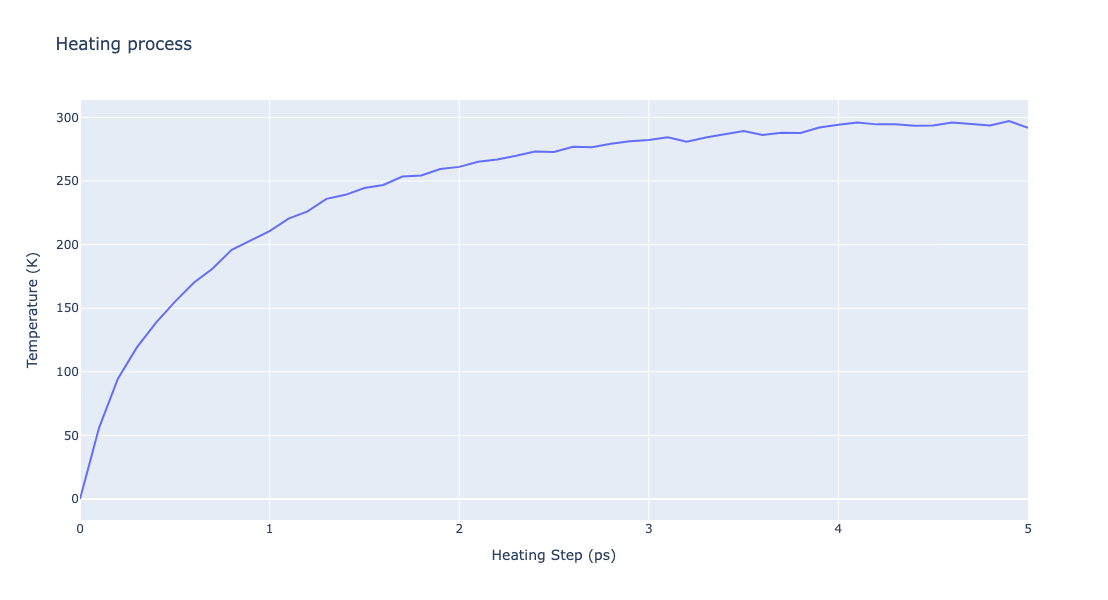

In [26]:
import plotly.graph_objs as go

with open(output_dat_heat_path, 'r') as energy_file:
    x, y = zip(*[
        (float(line.split()[0]), float(line.split()[1]))
        for line in energy_file
        if not line.startswith(("#", "@"))
        if float(line.split()[1]) < 1000
    ])

# Create a scatter plot
fig = go.Figure(data=go.Scatter(x=x, y=y, mode='lines'))

# Update layout
fig.update_layout(title="Heating process",
                  xaxis_title="Heating Step (ps)",
                  yaxis_title="Temperature (K)",
                  height=600)

# Show the figure (renderer changes for colab and jupyter)
rend = 'colab' if 'google.colab' in sys.modules else ''
fig.show(renderer=rend)

<a id="nvt"></a>
***
## Equilibrate the system (NVT)
Equilibrate the **protein system** in **NVT ensemble** (constant Number of particles, Volume and Temperature). Protein **heavy atoms** will be restrained using position restraining forces: movement is permitted, but only after overcoming a substantial energy penalty. The utility of position restraints is that they allow us to equilibrate our solvent around our protein, without the added variable of structural changes in the protein.

- [Step 1](#eqNVTStep1): Equilibrate the **protein system** with **NVT** ensemble.
- [Step 2](#eqNVTStep2): Checking **NVT Equilibration** results. Plotting **system temperature** by time during the **NVT equilibration** process.  
***
**Building Blocks** used:
 - [sander_mdrun](https://biobb-amber.readthedocs.io/en/latest/sander.html#module-sander.sander_mdrun) from **biobb_amber.sander.sander_mdrun**
 - [process_mdout](https://biobb-amber.readthedocs.io/en/latest/process.html#module-process.process_mdout) from **biobb_amber.process.process_mdout** 
***

<a id="eqNVTStep1"></a>
### Step 1: Equilibrating the system (NVT)
The **nvt** type of the **simulation_type property** contains the main default parameters to run a **system equilibration in NVT ensemble**:

-  imin = 0;&nbsp;&nbsp;&nbsp;      Run MD (no minimization)
-  ntx = 5;&nbsp;&nbsp;&nbsp;       Read initial coords and vels from restart file
-  cut = 10.0;&nbsp;&nbsp;&nbsp;    Cutoff for non bonded interactions in Angstroms
-  ntr = 0;&nbsp;&nbsp;&nbsp;       No restrained atoms
-  ntc = 2;&nbsp;&nbsp;&nbsp;       SHAKE for constraining length of bonds involving Hydrogen atoms
-  ntf = 2;&nbsp;&nbsp;&nbsp;       Bond interactions involving H omitted
-  ntt = 3;&nbsp;&nbsp;&nbsp;       Constant temperature using Langevin dynamics
-  ig = -1;&nbsp;&nbsp;&nbsp;       Seed for pseudo-random number generator
-  ioutfm = 1;&nbsp;&nbsp;&nbsp;    Write trajectory in netcdf format
-  iwrap = 1;&nbsp;&nbsp;&nbsp;     Wrap coords into primary box
-  nstlim = 5000;&nbsp;&nbsp;&nbsp; Number of MD steps 
-  dt = 0.002;&nbsp;&nbsp;&nbsp;    Time step (in ps)
-  irest = 1;&nbsp;&nbsp;&nbsp;     Restart previous simulation
-  ntb = 1;&nbsp;&nbsp;&nbsp;       Periodic boundary conditions at constant volume
-  gamma_ln = 5.0;&nbsp;&nbsp;&nbsp;   Collision frequency for Langevin dynamics (in 1/ps)

In this particular example, the **NVT equilibration** of the system is done in **500 steps** (note that the number of steps has been reduced in this tutorial, for the sake of time). 

In [27]:
# Import module
from biobb_amber.sander.sander_mdrun import sander_mdrun

# Create prop dict and inputs/outputs
output_nvt_traj_path = 'sander.nvt.netcdf'
output_nvt_rst_path = 'sander.nvt.rst'
output_nvt_log_path = 'sander.nvt.log'

prop = {
    "simulation_type" : 'nvt',
    "mdin" : { 
        'nstlim' : 500, # Reducing the number of steps for the sake of time (1ps)
        'ntr' : 1,      # Overwritting restrain parameter
        'restraintmask' : '\"!:WAT,Cl-,Na+ & !@H=\"',      # Restraining solute heavy atoms
        'restraint_wt' : 5.0                               # With a force constant of 5 Kcal/mol*A2
    }
}

# Create and launch bb
sander_mdrun(input_top_path=output_ions_top_path,
            input_crd_path=output_heat_rst_path,
            input_ref_path=output_heat_rst_path,
            output_traj_path=output_nvt_traj_path,
            output_rst_path=output_nvt_rst_path,
            output_log_path=output_nvt_log_path,
            properties=prop)

2025-07-31 15:55:33,962 [MainThread  ] [INFO ]  Module: biobb_amber.sander.sander_mdrun Version: 5.1.0
2025-07-31 15:55:33,963 [MainThread  ] [INFO ]  /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_c6f0838c-f4d6-439c-b267-ad4218ac6e20 directory successfully created
2025-07-31 15:55:33,965 [MainThread  ] [INFO ]  Copy: structure.ions.parmtop to /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_c6f0838c-f4d6-439c-b267-ad4218ac6e20
2025-07-31 15:55:33,967 [MainThread  ] [INFO ]  Copy: sander.heat.rst to /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_c6f0838c-f4d6-439c-b267-ad4218ac6e20
2025-07-31 15:55:33,968 [MainThread  ] [INFO ]  Copy: sander.heat.rst to /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_c6f0838c-f4d6-439c-b267-ad4218ac6e20
2025-07-31 15:55:33,969 [MainThread  ] [INFO ]  Creating ce991758-9d1b-4662-bef9-919d7f95f5f7 temporary folder
2025-07-31 15:55:33,970 [MainThread  ] [I

/Users/gbayarri/miniconda3/envs/biobb_wf_amber/lib/python3.12/site-packages/biobb_common/tools/file_utils.py:771: UserWarning:

Path sander.nvt.netcdf --- biobb_amber.sander.sander_mdrun: Unexisting output_traj_path file.



0

<a id="eqNVTStep2"></a>
### Step 2: Checking NVT Equilibration results
Checking **NVT Equilibration** results. Plotting **system temperature** by time during the NVT equilibration process. 

In [28]:
# Import module
from biobb_amber.process.process_mdout import process_mdout

# Create prop dict and inputs/outputs
output_dat_nvt_path = 'sander.md.nvt.temp.dat'

prop = {
    "terms" : ['TEMP']
}

# Create and launch bb
process_mdout(input_log_path=output_nvt_log_path,
            output_dat_path=output_dat_nvt_path,
            properties=prop)

2025-07-31 15:56:30,113 [MainThread  ] [INFO ]  Module: biobb_amber.process.process_mdout Version: 5.1.0
2025-07-31 15:56:30,113 [MainThread  ] [INFO ]  /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_461b5216-d6e7-4e53-90a6-7499c037196a directory successfully created
2025-07-31 15:56:30,115 [MainThread  ] [INFO ]  Copy: sander.nvt.log to /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_461b5216-d6e7-4e53-90a6-7499c037196a
2025-07-31 15:56:30,115 [MainThread  ] [INFO ]  Creating 4ca06912-59b6-4ad0-8c10-f118b4389792 temporary folder
2025-07-31 15:56:30,116 [MainThread  ] [INFO ]  cd 4ca06912-59b6-4ad0-8c10-f118b4389792 ; process_mdout.perl /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_461b5216-d6e7-4e53-90a6-7499c037196a/sander.nvt.log

2025-07-31 15:56:30,154 [MainThread  ] [INFO ]  Executing: cd 4ca06912-59b6-4ad0-8c10-f118b4389792 ; process_mdout.perl /Users/gbayarri/bio...
2025-07-31 15:56:30,155 [MainThread

0

In [29]:
import plotly.graph_objs as go

with open(output_dat_nvt_path, 'r') as energy_file:
    x, y = zip(*[
        (float(line.split()[0]), float(line.split()[1]))
        for line in energy_file
        if not line.startswith(("#", "@"))
        if float(line.split()[1]) < 1000
    ])

# Create a scatter plot
fig = go.Figure(data=go.Scatter(x=x, y=y, mode='lines'))

# Update layout
fig.update_layout(title="NVT equilibration",
                  xaxis_title="Equilibration Step (ps)",
                  yaxis_title="Temperature (K)",
                  height=600)

# Show the figure (renderer changes for colab and jupyter)
rend = 'colab' if 'google.colab' in sys.modules else ''
fig.show(renderer=rend)

<a id="npt"></a>
***
## Equilibrate the system (NPT)
Equilibrate the **protein system** in **NPT ensemble** (constant Number of particles, Pressure and Temperature). Protein **heavy atoms** will be restrained using position restraining forces: movement is permitted, but only after overcoming a substantial energy penalty. The utility of position restraints is that they allow us to equilibrate our solvent around our protein, without the added variable of structural changes in the protein.

- [Step 1](#eqNPTStep1): Equilibrate the **protein system** with **NPT** ensemble.
- [Step 2](#eqNPTStep2): Checking **NPT Equilibration** results. Plotting **system pressure and density** by time during the **NVT equilibration** process.  
***
**Building Blocks** used:
 - [sander_mdrun](https://biobb-amber.readthedocs.io/en/latest/sander.html#module-sander.sander_mdrun) from **biobb_amber.sander.sander_mdrun**
 - [process_mdout](https://biobb-amber.readthedocs.io/en/latest/process.html#module-process.process_mdout) from **biobb_amber.process.process_mdout** 
***

<a id="eqNPTStep1"></a>
### Step 1: Equilibrating the system (NPT)
The **npt** type of the **simulation_type property** contains the main default parameters to run a **system equilibration in NPT ensemble**:

-  imin = 0;&nbsp;&nbsp;&nbsp;      Run MD (no minimization)
-  ntx = 5;&nbsp;&nbsp;&nbsp;       Read initial coords and vels from restart file
-  cut = 10.0;&nbsp;&nbsp;&nbsp;    Cutoff for non bonded interactions in Angstroms
-  ntr = 0;&nbsp;&nbsp;&nbsp;       No restrained atoms
-  ntc = 2;&nbsp;&nbsp;&nbsp;       SHAKE for constraining length of bonds involving Hydrogen atoms
-  ntf = 2;&nbsp;&nbsp;&nbsp;       Bond interactions involving H omitted
-  ntt = 3;&nbsp;&nbsp;&nbsp;       Constant temperature using Langevin dynamics
-  ig = -1;&nbsp;&nbsp;&nbsp;       Seed for pseudo-random number generator
-  ioutfm = 1;&nbsp;&nbsp;&nbsp;    Write trajectory in netcdf format
-  iwrap = 1;&nbsp;&nbsp;&nbsp;     Wrap coords into primary box
-  nstlim = 5000;&nbsp;&nbsp;&nbsp; Number of MD steps 
-  dt = 0.002;&nbsp;&nbsp;&nbsp;    Time step (in ps)
-  irest = 1;&nbsp;&nbsp;&nbsp;     Restart previous simulation
-  gamma_ln = 5.0;&nbsp;&nbsp;&nbsp;   Collision frequency for Langevin dynamics (in 1/ps)
-  pres0 = 1.0;&nbsp;&nbsp;&nbsp;   Reference pressure
-  ntp = 1;&nbsp;&nbsp;&nbsp;       Constant pressure dynamics: md with isotropic position scaling
-  taup = 2.0;&nbsp;&nbsp;&nbsp;    Pressure relaxation time (in ps)

In this particular example, the **NPT equilibration** of the system is done in **500 steps** (note that the number of steps has been reduced in this tutorial, for the sake of time). 

In [30]:
# Import module
from biobb_amber.sander.sander_mdrun import sander_mdrun

# Create prop dict and inputs/outputs
output_npt_traj_path = 'sander.npt.netcdf'
output_npt_rst_path = 'sander.npt.rst'
output_npt_log_path = 'sander.npt.log'

prop = {
    "simulation_type" : 'npt',
    "mdin" : { 
        'nstlim' : 500, # Reducing the number of steps for the sake of time (1ps)
        'ntr' : 1,      # Overwritting restrain parameter
        'restraintmask' : '\"!:WAT,Cl-,Na+ & !@H=\"',      # Restraining solute heavy atoms
        'restraint_wt' : 2.5                               # With a force constant of 2.5 Kcal/mol*A2
    }
}

# Create and launch bb
sander_mdrun(input_top_path=output_ions_top_path,
            input_crd_path=output_nvt_rst_path,
            input_ref_path=output_nvt_rst_path,
            output_traj_path=output_npt_traj_path,
            output_rst_path=output_npt_rst_path,
            output_log_path=output_npt_log_path,
            properties=prop)

2025-07-31 15:56:30,179 [MainThread  ] [INFO ]  Module: biobb_amber.sander.sander_mdrun Version: 5.1.0
2025-07-31 15:56:30,179 [MainThread  ] [INFO ]  /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_0eea0bb8-ad62-444a-8bc4-d936488c8951 directory successfully created
2025-07-31 15:56:30,182 [MainThread  ] [INFO ]  Copy: structure.ions.parmtop to /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_0eea0bb8-ad62-444a-8bc4-d936488c8951
2025-07-31 15:56:30,183 [MainThread  ] [INFO ]  Copy: sander.nvt.rst to /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_0eea0bb8-ad62-444a-8bc4-d936488c8951
2025-07-31 15:56:30,184 [MainThread  ] [INFO ]  Copy: sander.nvt.rst to /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_0eea0bb8-ad62-444a-8bc4-d936488c8951
2025-07-31 15:56:30,185 [MainThread  ] [INFO ]  Creating abeaf4ef-310d-4f30-9c3e-dc65a049a1d5 temporary folder
2025-07-31 15:56:30,186 [MainThread  ] [INF

/Users/gbayarri/miniconda3/envs/biobb_wf_amber/lib/python3.12/site-packages/biobb_common/tools/file_utils.py:771: UserWarning:

Path sander.npt.netcdf --- biobb_amber.sander.sander_mdrun: Unexisting output_traj_path file.



0

<a id="eqNPTStep2"></a>
### Step 2: Checking NPT Equilibration results
Checking **NPT Equilibration** results. Plotting **system pressure and density** by time during the **NPT equilibration** process. 

In [31]:
# Import module
from biobb_amber.process.process_mdout import process_mdout

# Create prop dict and inputs/outputs
output_dat_npt_path = 'sander.md.npt.dat'

prop = {
    "terms" : ['PRES','DENSITY']
}

# Create and launch bb
process_mdout(input_log_path=output_npt_log_path,
            output_dat_path=output_dat_npt_path,
            properties=prop)

2025-07-31 15:57:26,870 [MainThread  ] [INFO ]  Module: biobb_amber.process.process_mdout Version: 5.1.0
2025-07-31 15:57:26,870 [MainThread  ] [INFO ]  /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_20fbbab5-c53d-4f01-ab91-cf38a3557333 directory successfully created
2025-07-31 15:57:26,872 [MainThread  ] [INFO ]  Copy: sander.npt.log to /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_20fbbab5-c53d-4f01-ab91-cf38a3557333
2025-07-31 15:57:26,872 [MainThread  ] [INFO ]  Creating 50b47a0c-96c1-4c99-ae8b-0a007dc104f6 temporary folder
2025-07-31 15:57:26,873 [MainThread  ] [INFO ]  cd 50b47a0c-96c1-4c99-ae8b-0a007dc104f6 ; process_mdout.perl /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_20fbbab5-c53d-4f01-ab91-cf38a3557333/sander.npt.log

2025-07-31 15:57:26,909 [MainThread  ] [INFO ]  Executing: cd 50b47a0c-96c1-4c99-ae8b-0a007dc104f6 ; process_mdout.perl /Users/gbayarri/bio...
2025-07-31 15:57:26,910 [MainThread

0

In [32]:
# Read pressure and density data from file 
import plotly.graph_objs as go

# Read pressure and density data from file 
with open(output_dat_npt_path, 'r') as pd_file:
    x, y, z = zip(*[
        (float(line.split()[0]), float(line.split()[1]), float(line.split()[2]))
        for line in pd_file
        if not line.startswith(("#", "@"))
        if float(line.split()[1]) < 1000
    ])

# Create a scatter plot
trace1 = go.Scatter(
    x=x,y=y
)
trace2 = go.Scatter(
    x=x,y=z
)

fig = subplots.make_subplots(rows=1, cols=2, print_grid=False)

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)

fig['layout']['xaxis1'].update(title='Time (ps)')
fig['layout']['xaxis2'].update(title='Time (ps)')
fig['layout']['yaxis1'].update(title='Pressure (bar)')
fig['layout']['yaxis2'].update(title='Density (Kg*m^-3)')

fig['layout'].update(title='Pressure and Density during NPT Equilibration')
fig['layout'].update(showlegend=False)
fig['layout'].update(height=500)

# Show the figure (renderer changes for colab and jupyter)
rend = 'colab' if 'google.colab' in sys.modules else ''
fig.show(renderer=rend)

<a id="free"></a>
***
## Free Molecular Dynamics Simulation
Upon completion of the **two equilibration phases (NVT and NPT)**, the system is now well-equilibrated at the desired temperature and pressure. The **position restraints** can now be released. The last step of the **protein** MD setup is a short, **free MD simulation**, to ensure the robustness of the system. 
- [Step 1](#mdStep1): Run short MD simulation of the **protein system**.
- [Step 2](#mdStep2): Checking results for the final step of the setup process, the **free MD run**. Plotting **Root Mean Square deviation (RMSd)** and **Radius of Gyration (Rgyr)** by time during the **free MD run** step.
***
**Building Blocks** used:
 - [sander_mdrun](https://biobb-amber.readthedocs.io/en/latest/sander.html#module-sander.sander_mdrun) from **biobb_amber.sander.sander_mdrun**
 - [process_mdout](https://biobb-amber.readthedocs.io/en/latest/process.html#module-process.process_mdout) from **biobb_amber.process.process_mdout** 
 - [cpptraj_rms](https://biobb-analysis.readthedocs.io/en/latest/ambertools.html#module-ambertools.cpptraj_rms) from **biobb_analysis.cpptraj.cpptraj_rms**
 - [cpptraj_rgyr](https://biobb-analysis.readthedocs.io/en/latest/ambertools.html#module-ambertools.cpptraj_rgyr) from **biobb_analysis.cpptraj.cpptraj_rgyr**
***

<a id="mdStep1"></a>
### Step 1: Creating portable binary run file to run a free MD simulation

The **free** type of the **simulation_type property** contains the main default parameters to run an **unrestrained MD simulation**:

-  imin = 0;&nbsp;&nbsp;&nbsp;      Run MD (no minimization)
-  ntx = 5;&nbsp;&nbsp;&nbsp;       Read initial coords and vels from restart file
-  cut = 10.0;&nbsp;&nbsp;&nbsp;    Cutoff for non bonded interactions in Angstroms
-  ntr = 0;&nbsp;&nbsp;&nbsp;       No restrained atoms
-  ntc = 2;&nbsp;&nbsp;&nbsp;       SHAKE for constraining length of bonds involving Hydrogen atoms
-  ntf = 2;&nbsp;&nbsp;&nbsp;       Bond interactions involving H omitted
-  ntt = 3;&nbsp;&nbsp;&nbsp;       Constant temperature using Langevin dynamics
-  ig = -1;&nbsp;&nbsp;&nbsp;       Seed for pseudo-random number generator
-  ioutfm = 1;&nbsp;&nbsp;&nbsp;    Write trajectory in netcdf format
-  iwrap = 1;&nbsp;&nbsp;&nbsp;     Wrap coords into primary box
-  nstlim = 5000;&nbsp;&nbsp;&nbsp; Number of MD steps 
-  dt = 0.002;&nbsp;&nbsp;&nbsp;    Time step (in ps)

In this particular example, a short, **5ps-length** simulation (2500 steps) is run, for the sake of time. 

In [33]:
# Import module
from biobb_amber.sander.sander_mdrun import sander_mdrun

# Create prop dict and inputs/outputs
output_free_traj_path = 'sander.free.netcdf'
output_free_rst_path = 'sander.free.rst'
output_free_log_path = 'sander.free.log'

prop = {
    "simulation_type" : 'free',
    "mdin" : { 
        'nstlim' : 2500, # Reducing the number of steps for the sake of time (5ps)
        'ntwx' : 500  # Print coords to trajectory every 500 steps (1 ps)
    }
}

# Create and launch bb
sander_mdrun(input_top_path=output_ions_top_path,
            input_crd_path=output_npt_rst_path,
            output_traj_path=output_free_traj_path,
            output_rst_path=output_free_rst_path,
            output_log_path=output_free_log_path,
            properties=prop)

2025-07-31 15:57:26,961 [MainThread  ] [INFO ]  Module: biobb_amber.sander.sander_mdrun Version: 5.1.0
2025-07-31 15:57:26,962 [MainThread  ] [INFO ]  /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_f2bb6ded-6512-49d6-8e38-7c5fe0767bfa directory successfully created
2025-07-31 15:57:26,964 [MainThread  ] [INFO ]  Copy: structure.ions.parmtop to /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_f2bb6ded-6512-49d6-8e38-7c5fe0767bfa
2025-07-31 15:57:26,966 [MainThread  ] [INFO ]  Copy: sander.npt.rst to /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_f2bb6ded-6512-49d6-8e38-7c5fe0767bfa
2025-07-31 15:57:26,966 [MainThread  ] [INFO ]  Creating 778f63d2-292b-4b2d-8c07-5d17bed8810e temporary folder
2025-07-31 15:57:26,968 [MainThread  ] [INFO ]  sander -O -i 778f63d2-292b-4b2d-8c07-5d17bed8810e/sander.mdin -p /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_f2bb6ded-6512-49d6-8e38-7c5fe0767bfa/st

0

<a id="mdStep2"></a>
### Step 2: Checking free MD simulation results

Checking results for the final step of the setup process, the **free MD run**. Plotting **Root Mean Square deviation (RMSd)** and **Radius of Gyration (Rgyr)** by time during the **free MD run** step. **RMSd** against the **experimental structure** (input structure of the pipeline) and against the **minimized and equilibrated structure** (output structure of the NPT equilibration step).

In [34]:
# cpptraj_rms: Computing Root Mean Square deviation to analyse structural stability 
#              RMSd against minimized and equilibrated snapshot (backbone atoms)   

# Import module
from biobb_analysis.ambertools.cpptraj_rms import cpptraj_rms

# Create prop dict and inputs/outputs
output_rms_first = pdbCode+'_rms_first.dat'

prop = {
    'mask': 'backbone',
    'reference': 'first'
}

# Create and launch bb
cpptraj_rms(input_top_path=output_ions_top_path,
            input_traj_path=output_free_traj_path,
            output_cpptraj_path=output_rms_first,
            properties=prop)

2025-07-31 16:01:52,971 [MainThread  ] [INFO ]  Module: biobb_analysis.ambertools.cpptraj_rms Version: 5.1.0
2025-07-31 16:01:52,971 [MainThread  ] [INFO ]  /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_4bc36a01-73b9-4ef1-98a7-04ac094c3f0e directory successfully created
2025-07-31 16:01:52,973 [MainThread  ] [INFO ]  Copy: structure.ions.parmtop to /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_4bc36a01-73b9-4ef1-98a7-04ac094c3f0e
2025-07-31 16:01:52,975 [MainThread  ] [INFO ]  Copy: sander.free.netcdf to /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_4bc36a01-73b9-4ef1-98a7-04ac094c3f0e
2025-07-31 16:01:52,976 [MainThread  ] [INFO ]  cpptraj -i d5e6b98f-242b-437e-aa4c-5e16b4ab3c3e/instructions.in

2025-07-31 16:01:53,163 [MainThread  ] [INFO ]  Executing: cpptraj -i d5e6b98f-242b-437e-aa4c-5e16b4ab3c3e/instructions.in...
2025-07-31 16:01:53,165 [MainThread  ] [INFO ]  Exit code: 0
2025-07-31 16:01:53,165 [M

0

In [35]:
# cpptraj_rms: Computing Root Mean Square deviation to analyse structural stability 
#              RMSd against experimental structure (backbone atoms)   

# Import module
from biobb_analysis.ambertools.cpptraj_rms import cpptraj_rms

# Create prop dict and inputs/outputs
output_rms_exp = pdbCode+'_rms_exp.dat'

prop = {
    'mask': 'backbone',
    'reference': 'experimental'
}

# Create and launch bb
cpptraj_rms(input_top_path=output_ions_top_path,
            input_traj_path=output_free_traj_path,
            output_cpptraj_path=output_rms_exp,
            input_exp_path=downloaded_pdb, 
            properties=prop)

2025-07-31 16:01:53,178 [MainThread  ] [INFO ]  Module: biobb_analysis.ambertools.cpptraj_rms Version: 5.1.0
2025-07-31 16:01:53,179 [MainThread  ] [INFO ]  /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_2107095b-ac0c-4d6c-b38d-81ec02967ab7 directory successfully created
2025-07-31 16:01:53,181 [MainThread  ] [INFO ]  Copy: structure.ions.parmtop to /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_2107095b-ac0c-4d6c-b38d-81ec02967ab7
2025-07-31 16:01:53,183 [MainThread  ] [INFO ]  Copy: sander.free.netcdf to /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_2107095b-ac0c-4d6c-b38d-81ec02967ab7
2025-07-31 16:01:53,184 [MainThread  ] [INFO ]  Copy: 1aki.pdb to /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_2107095b-ac0c-4d6c-b38d-81ec02967ab7
2025-07-31 16:01:53,185 [MainThread  ] [INFO ]  cpptraj -i 151b7746-19f3-492a-92c9-df4b7d2bbc3b/instructions.in

2025-07-31 16:01:53,419 [MainThread  

0

In [36]:
import plotly.graph_objs as go

# Read RMS vs first snapshot data from file 
with open(output_rms_first, 'r') as rms_first_file:
    x, y = zip(*[
        (float(line.split()[0]), float(line.split()[1]))
        for line in rms_first_file
        if not line.startswith(("#", "@"))
        if float(line.split()[1]) < 1000
    ])

# Read RMS vs experimental structure data from file 
with open(output_rms_exp, 'r') as rms_exp_file:
    x2, y2 = zip(*[
        (float(line.split()[0]), float(line.split()[1]))
        for line in rms_exp_file
        if not line.startswith(("#", "@"))
        if float(line.split()[1]) < 1000
    ])

# Create a scatter plot
fig = go.Figure(data=[go.Scatter(x=x, y=y, name = 'RMSd vs first'), go.Scatter(x=x, y=y2, name = 'RMSd vs exp')])

# Update layout
fig.update_layout(title="RMSd during free MD Simulation",
                  xaxis_title="Time (ps)",
                  yaxis_title="RMSd (Angstrom)",
                  height=600)

# Show the figure (renderer changes for colab and jupyter)
rend = 'colab' if 'google.colab' in sys.modules else ''
fig.show(renderer=rend)


In [37]:
# cpptraj_rgyr: Computing Radius of Gyration to measure the protein compactness during the free MD simulation 

# Import module
from biobb_analysis.ambertools.cpptraj_rgyr import cpptraj_rgyr

# Create prop dict and inputs/outputs
output_rgyr = pdbCode+'_rgyr.dat'

prop = {
    'mask': 'backbone'
}

# Create and launch bb
cpptraj_rgyr(input_top_path=output_ions_top_path,
            input_traj_path=output_free_traj_path,
            output_cpptraj_path=output_rgyr,
            properties=prop)


2025-07-31 16:01:53,442 [MainThread  ] [INFO ]  Module: biobb_analysis.ambertools.cpptraj_rgyr Version: 5.1.0
2025-07-31 16:01:53,443 [MainThread  ] [INFO ]  /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_39c26716-b87d-4cf7-acb5-69d59aa5e666 directory successfully created
2025-07-31 16:01:53,445 [MainThread  ] [INFO ]  Copy: structure.ions.parmtop to /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_39c26716-b87d-4cf7-acb5-69d59aa5e666
2025-07-31 16:01:53,446 [MainThread  ] [INFO ]  Copy: sander.free.netcdf to /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_39c26716-b87d-4cf7-acb5-69d59aa5e666
2025-07-31 16:01:53,447 [MainThread  ] [INFO ]  cpptraj -i 20fd01a2-70f0-4a70-8509-3dbd168cea45/instructions.in

2025-07-31 16:01:53,646 [MainThread  ] [INFO ]  Executing: cpptraj -i 20fd01a2-70f0-4a70-8509-3dbd168cea45/instructions.in...
2025-07-31 16:01:53,647 [MainThread  ] [INFO ]  Exit code: 0
2025-07-31 16:01:53,648 [

0

In [38]:
# Read Rgyr data from file 
import plotly.graph_objs as go

with open(output_rgyr, 'r') as rgyr_file:
    x, y = zip(*[
        (float(line.split()[0]), float(line.split()[1]))
        for line in rgyr_file
        if not line.startswith(("#", "@"))
        if float(line.split()[1]) < 1000
    ])

# Create a scatter plot
fig = go.Figure(data=go.Scatter(x=x, y=y, mode='lines'))

# Update layout
fig.update_layout(title="Radius of Gyration",
                  xaxis_title="Time (ps)",
                  yaxis_title="Rgyr (Angstrom)",
                  height=600)

# Show the figure (renderer changes for colab and jupyter)
rend = 'colab' if 'google.colab' in sys.modules else ''
fig.show(renderer=rend)

<a id="post"></a>
***
## Post-processing and Visualizing resulting 3D trajectory
Post-processing and Visualizing the **protein system** MD setup **resulting trajectory** using **NGL**
- [Step 1](#ppStep1): *Imaging* the resulting trajectory, **stripping out water molecules and ions** and **correcting periodicity issues**.
- [Step 2](#ppStep3): Visualizing the *imaged* trajectory using the *dry* structure as a **topology**. 
***
**Building Blocks** used:
 - [cpptraj_image](https://biobb-analysis.readthedocs.io/en/latest/ambertools.html#module-ambertools.cpptraj_image) from **biobb_analysis.cpptraj.cpptraj_image** 
***

<a id="ppStep1"></a>
### Step 1: *Imaging* the resulting trajectory.
Stripping out **water molecules and ions** and **correcting periodicity issues**  

In [39]:
# cpptraj_image: "Imaging" the resulting trajectory
#                Removing water molecules and ions from the resulting structure

# Import module
from biobb_analysis.ambertools.cpptraj_image import cpptraj_image

# Create prop dict and inputs/outputs
output_imaged_traj = pdbCode+'_imaged_traj.trr'

prop = {
    'mask': 'solute',
    'format': 'trr'
}

# Create and launch bb
cpptraj_image(input_top_path=output_ions_top_path,
            input_traj_path=output_free_traj_path,
            output_cpptraj_path=output_imaged_traj,
            properties=prop)

2025-07-31 16:01:53,669 [MainThread  ] [INFO ]  Module: biobb_analysis.ambertools.cpptraj_image Version: 5.1.0
2025-07-31 16:01:53,670 [MainThread  ] [INFO ]  /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_07936bf6-5da5-4c61-acd4-d85e1a6afbf3 directory successfully created
2025-07-31 16:01:53,672 [MainThread  ] [INFO ]  Copy: structure.ions.parmtop to /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_07936bf6-5da5-4c61-acd4-d85e1a6afbf3
2025-07-31 16:01:53,673 [MainThread  ] [INFO ]  Copy: sander.free.netcdf to /Users/gbayarri/biobb_wf_amber/biobb_wf_amber/notebooks/md_setup/sandbox_07936bf6-5da5-4c61-acd4-d85e1a6afbf3
2025-07-31 16:01:53,674 [MainThread  ] [INFO ]  cpptraj -i fb59356f-a62e-4d57-a40a-347b435e50b2/instructions.in

2025-07-31 16:01:53,845 [MainThread  ] [INFO ]  Executing: cpptraj -i fb59356f-a62e-4d57-a40a-347b435e50b2/instructions.in...
2025-07-31 16:01:53,846 [MainThread  ] [INFO ]  Exit code: 0
2025-07-31 16:01:53,847 

0

<a id="ppStep2"></a>
### Step 2: Visualizing the generated dehydrated trajectory.
Using the **imaged trajectory** (output of the [Post-processing step 1](#ppStep1)) with the **dry structure** (output of the [Structure energy minimization - step 5](#minv)) as a topology.

In [41]:
# Show trajectory
view = nglview.show_simpletraj(nglview.SimpletrajTrajectory(output_imaged_traj, output_ambpdb_path), gui=True)
view

NGLWidget(max_frame=4)

<a id="output"></a>
## Output files

Important **Output files** generated:
 - **output_ions_pdb_path** (structure.ions.pdb): **System structure** of the MD setup protocol. Structure generated during the MD setup and used in the MD simulation. With hydrogen atoms, solvent box and counterions.  
 - **output_free_traj_path** (sander.free.netcdf): **Final trajectory** of the MD setup protocol.
 - **output_free_rst_path** (sander.free.rst): **Final checkpoint file**, with information about the state of the simulation. It can be used to **restart** or **continue** a MD simulation.
 - **output_ions_top_path** (structure.ions.parmtop): **Final topology** of the MD system in AMBER Parm7 format.

**Analysis** (MD setup check) output files generated:
 - **output_rms_first** (1aki_rms_first.dat): **Root Mean Square deviation (RMSd)** against **minimized and equilibrated structure** of the final **free MD run step**.
 - **output_rms_exp** (1aki_rms_exp.dat): **Root Mean Square deviation (RMSd)** against **experimental structure** of the final **free MD run step**.
 - **output_rgyr** (1aki_rgyr.dat): **Radius of Gyration** of the final **free MD run step** of the **setup pipeline**.
 

***
<a id="questions"></a>

## Questions & Comments

Questions, issues, suggestions and comments are really welcome!

* GitHub issues:
    * [https://github.com/bioexcel/biobb](https://github.com/bioexcel/biobb)

* BioExcel forum:
    * [https://ask.bioexcel.eu/c/BioExcel-Building-Blocks-library](https://ask.bioexcel.eu/c/BioExcel-Building-Blocks-library)
